# Conhecendo os dados

In [34]:
import pandas as pd

In [35]:
dados = pd.read_csv('dados_inadimplencia.csv')
dados.head()


,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,16855.246324,2997.000000,12.157324,0,2.0,0.501213,0.003109,0.513171,0.117428,243.0,1
1,13500.000000,2776.050000,12.157324,0,2.0,0.501213,0.269730,0.513171,0.097900,617.0,0
2,11250.000000,2722.188351,12.157324,0,3.0,0.701396,0.518625,0.700184,0.118600,9.0,0
3,27000.000000,6750.000000,3.000000,0,2.0,0.501213,0.649571,0.513171,0.047400,300.0,0
4,22500.000000,3097.800000,12.157324,0,2.0,0.440744,0.509677,0.513171,0.014400,2913.0,1


In [36]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14578 entries, 0 to 14577
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   receita_cliente      14578 non-null  float64
 1   anuidade_emprestimo  14578 non-null  float64
 2   anos_casa_propria    14578 non-null  float64
 3   telefone_trab        14578 non-null  int64  
 4   avaliacao_cidade     14578 non-null  float64
 5   score_1              14578 non-null  float64
 6   score_2              14578 non-null  float64
 7   score_3              14578 non-null  float64
 8   score_social         14578 non-null  float64
 9   troca_telefone       14578 non-null  float64
 10  inadimplente         14578 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 1.2 MB


In [37]:
dados['inadimplente'].value_counts(normalize=True)

inadimplente
0    0.676499
1    0.323501
Name: proportion, dtype: float64

In [38]:
x = dados.drop(columns='inadimplente', axis=1)
y = dados['inadimplente']

In [39]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, test_size=0.33, random_state=RANDOM_SEED)

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
modelo_dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_SEED)
modelo_dt.fit(x_treino, y_treino)



DecisionTreeClassifier(max_depth=3, random_state=42)

In [42]:
from sklearn.metrics import recall_score

recall_dt = recall_score(y_teste, modelo_dt.predict(x_teste))
print(f"Recall Decision Tree: {recall_dt}")

Recall Decision Tree: 0.14331619537275064


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [44]:
logistic_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logistic_pipeline.fit(x_treino, y_treino)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [45]:
recall_lr = recall_score(y_teste, logistic_pipeline.predict(x_teste))
print(f"Recall Logistic Regression: {recall_lr}")

Recall Logistic Regression: 0.2532133676092545


In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
import numpy as np

param_grid_dt = {
    'criterion':  ['gini', 'entropy'],
    'max_depth': np.linspace(6, 12, 4, dtype=int),
    'min_samples_split': np.linspace(5, 20, 4, dtype=int),
    'min_samples_leaf': np.linspace(5, 20, 4, dtype=int),
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}


In [48]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_SEED), 
             param_grid=param_grid_dt, 
             scoring='recall', 
             n_jobs=-1, 
             refit=True, 
             cv=cv)

dt_grid_search.fit(x_treino, y_treino)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  8, 10, 12]),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': array([ 5, 10, 15, 20]),
                         'min_samples_split': array([ 5, 10, 15, 20]),
                         'splitter': ['best', 'random']},
             scoring='recall')

In [49]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 5,
 'splitter': 'best'}

In [50]:
df_cv_results_dt = pd.DataFrame(dt_grid_search.cv_results_)
df_cv_results_dt.sort_values(by='rank_test_score').head()



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
240,0.015887,0.002043,0.004844,0.001359,gini,12,log2,15,5,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1
246,0.019352,0.003721,0.006833,0.003238,gini,12,log2,15,20,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1
208,0.015552,0.003121,0.005604,0.003730,gini,12,sqrt,15,5,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1
212,0.016319,0.003458,0.004300,0.001798,gini,12,sqrt,15,15,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1
210,0.013745,0.001655,0.003272,0.000367,gini,12,sqrt,15,10,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1


In [51]:
df_cv_results_dt.loc[[dt_grid_search.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
208,0.015552,0.003121,0.005604,0.00373,gini,12,sqrt,15,5,best,"{'criterion': 'gini', 'max_depth': 12, 'max_fe...",0.242089,0.324367,0.272152,0.245253,0.232595,0.263291,0.033244,1


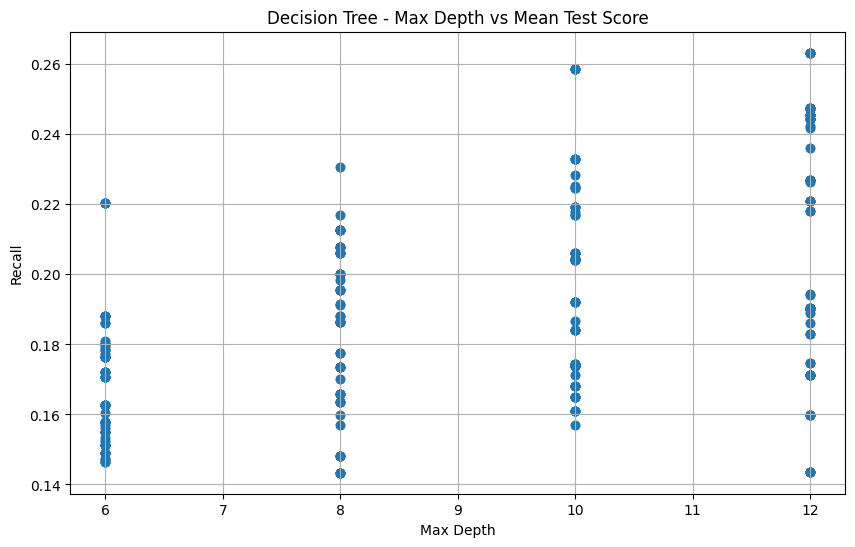

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_max_depth'],
    df_cv_results_dt['mean_test_score'],
)

plt.title('Decision Tree - Max Depth vs Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Recall')
plt.grid()

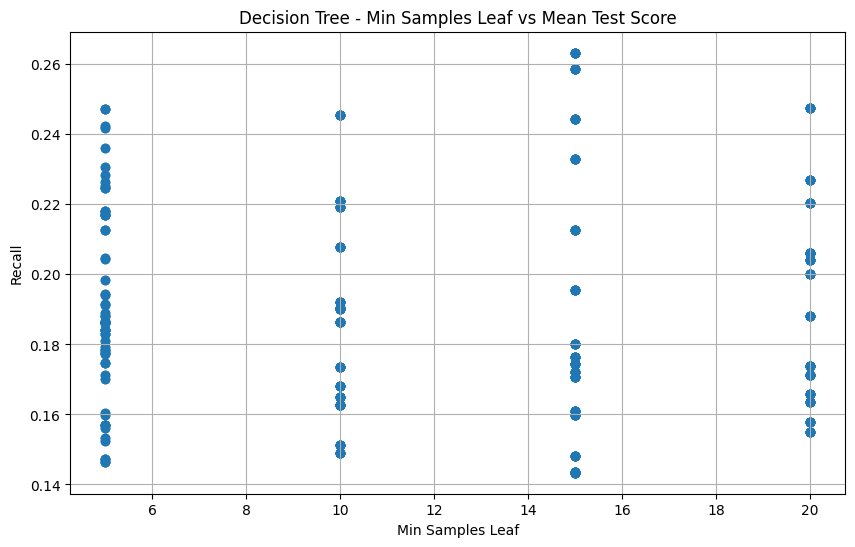

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_dt['param_min_samples_leaf'],
    df_cv_results_dt['mean_test_score'],
)

plt.title('Decision Tree - Min Samples Leaf vs Mean Test Score')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Recall')
plt.grid()

In [54]:
max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]


In [55]:
lr_grid_search = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
             param_grid=param_grid_lr, 
             scoring='recall', 
             n_jobs=-1, 
             refit=True, 
             cv=cv)

lr_grid_search.fit(x_treino, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l2'],
                          'logisticregression__solver': ['newton-cg', 'lbfgs']},
                         {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                          'logisticregression__penalty': ['l1', 'l2'],
                          'logisticregression__solver': ['liblinear']}],
             scoring='recall')

In [57]:
lr_grid_search.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [61]:
df_cv_results_lr = pd.DataFrame(lr_grid_search.cv_results_)
df_cv_results_lr.sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,0.016714,0.000989,0.005418,0.000387,0.001,150,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.251582,0.254747,0.265823,0.248418,0.235759,0.251266,0.009723,1
59,0.016356,0.001799,0.004512,0.000449,0.001,300,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.251582,0.254747,0.265823,0.248418,0.235759,0.251266,0.009723,1
57,0.014571,0.001657,0.004527,0.000549,0.001,250,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.251582,0.254747,0.265823,0.248418,0.235759,0.251266,0.009723,1


In [63]:
df_cv_results_lr.loc[[lr_grid_search.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__penalty,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
51,0.015106,0.002399,0.004093,0.000795,0.001,100,l2,liblinear,"{'logisticregression__C': 0.001, 'logisticregr...",0.251582,0.254747,0.265823,0.248418,0.235759,0.251266,0.009723,1


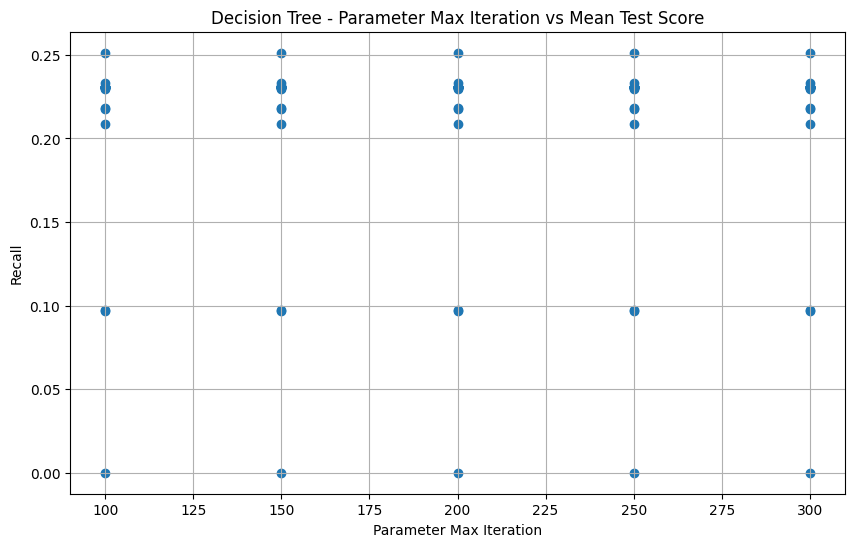

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_cv_results_lr['param_logisticregression__max_iter'],
    df_cv_results_lr['mean_test_score'],
)

plt.title('Decision Tree - Parameter Max Iteration vs Mean Test Score')
plt.xlabel('Parameter Max Iteration')
plt.ylabel('Recall')
plt.grid()